In [ ]:
!pip install mne
!pip install mne-icalabel
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Constants
FS = 128  # Sampling frequency
METADATA_COLUMNS =  [
    'EEG.Counter', 'EEG.Interpolated', 'EEG.RawCq', 'EEG.Battery',
    'EEG.BatteryPercent', 'EEG.MarkerHardware'
]

print("Libraries imported and constants initialized.")

Libraries imported and constants initialized.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function to combine participant CSVs for each word folder and store in a dictionary
def load_and_combine_participants(root_folder):
    combined_data = {}  # Dictionary to store combined data for each word

    for word_folder in os.listdir(root_folder):
        word_path = os.path.join(root_folder, word_folder)
        if not os.path.isdir(word_path):
            print(f"Skipping {word_path} (not a directory)")
            continue

        print(f"Processing word folder: {word_folder}")
        participant_data = []  # List to hold DataFrames for each participant

        for file in os.listdir(word_path):
            file_path = os.path.join(word_path, file)
            if not os.path.isfile(file_path) or not file.endswith('.csv'):
                print(f"  Skipping {file} (not a .csv file)")
                continue

            print(f"  Reading participant file: {file}")
            try:
                # Skip the first row while reading the CSV
                df = pd.read_csv(file_path, skiprows=1)

                # Use regular expression to extract the participant name (e.g., 'par.1', 'par.2')
                match = re.match(r'(par\.\d+)', file)
                if match:
                    participant_name = match.group(0)  # Extract the full participant name (e.g., 'par.1')
                    print(f"  Assigning participant name: {participant_name}")  # Debugging line
                    df['Participant'] = participant_name  # Add the participant name to the DataFrame
                else:
                    print(f"  No match for participant in filename: {file}")

                participant_data.append(df)
            except Exception as e:
                print(f"  Error reading {file_path}: {e}")
                continue

        # Combine all participant data into a single DataFrame for the word
        if participant_data:
            combined_df = pd.concat(participant_data, ignore_index=True)
            combined_data[word_folder] = combined_df
            print(f"  Combined data for {word_folder} loaded successfully.")
        else:
            print(f"  No valid participant files found in {word_folder}.")

    return combined_data

# Example usage
ROOT_FOLDER = r"/content/drive/MyDrive/ArEEG_Chars/احرف"

# Load the data
word_data = load_and_combine_participants(ROOT_FOLDER)

# Example check: Access combined data for a specific word
if 'ء' in word_data:
    print(f"Data for word ء:\n{word_data['ء']}")


Processing letter folder: ح
  Reading participant file: par.21 حاء_EPOCX_194172_2023.09.16T00.15.32+03.00.md.csv
  Assigning participant name: par.21
  Reading participant file: par.6 حاء_EPOCX_194172_2023.09.16T23.53.13+03.00.md.csv
  Assigning participant name: par.6
  Reading participant file: par.24 حاء_EPOCX_194172_2023.09.12T21.31.54+03.00.md.csv
  Assigning participant name: par.24
  Reading participant file: par.4 حاء_EPOCX_194172_2023.09.16T21.58.34+03.00.md.csv
  Assigning participant name: par.4
  Reading participant file: par.9 حاء_EPOCX_194172_2023.09.13T13.45.11+03.00.md.csv
  Assigning participant name: par.9
  Reading participant file: par.10 حاء_EPOCX_194172_2023.09.12T11.04.10+03.00.md.csv
  Assigning participant name: par.10
  Reading participant file: par.26 حاء_EPOCX_194172_2023.09.14T11.43.45+03.00.md.csv
  Assigning participant name: par.26
  Reading participant file: par.29 حاء_EPOCX_194172_2023.09.17T18.04.14+03.00.md.csv
  Assigning participant name: par.29
  

In [ ]:
# Function to validate EEG data for a DataFrame
def validate_eeg_data(df):
    # Define columns that start with "EEG." and are not in metadata columns
    valid_columns = [col for col in df.columns if col.startswith('EEG.') and col not in METADATA_COLUMNS]

    if not valid_columns:
        print(f"No valid EEG signal columns identified. Skipping this DataFrame.")
        return None, None  # Return None for both validated data and valid columns

    print(f"Validating data with shape: {df.shape}")
    return df[valid_columns].copy(), valid_columns  # Return DataFrame with valid columns

# Process word_data to validate EEG data for each word
validated_word_data = {}
valid_columns_map = {}  # To store valid columns for each word

for word, data in word_data.items():
    print(f"Processing data for word: {word}")
    validated_data, valid_columns = validate_eeg_data(data)  # Validate the EEG data
    if validated_data is not None:
        validated_word_data[word] = validated_data  # Store the validated data
        valid_columns_map[word] = valid_columns  # Store valid columns for this word
    else:
        print(f"  No valid EEG data for word: {word}")

Processing data for letter: ح
Validating data with shape: (41636, 69)
Processing data for letter: ج
Validating data with shape: (43300, 69)
Processing data for letter: د
Validating data with shape: (41659, 69)
Processing data for letter: ت
Validating data with shape: (41619, 69)
Processing data for letter: خ
Validating data with shape: (40353, 69)
Processing data for letter: ة
Validating data with shape: (41619, 69)
Processing data for letter: ء
Validating data with shape: (41736, 69)
Processing data for letter: أ
Validating data with shape: (41325, 69)
Processing data for letter: ث
Validating data with shape: (41585, 69)
Processing data for letter: ب
Validating data with shape: (41725, 69)
Processing data for letter: ظ
Validating data with shape: (41980, 69)
Processing data for letter: ر
Validating data with shape: (47152, 69)
Processing data for letter: ش
Validating data with shape: (42957, 69)
Processing data for letter: ط
Validating data with shape: (41691, 69)
Processing data for

In [ ]:
# Function to detect bad channels
def detect_bad_channels(eeg_data, valid_columns, z_threshold=3.0):
    bad_channels = []
    channel_variances = eeg_data.var(axis=0)
    z_scores = (channel_variances - channel_variances.mean()) / channel_variances.std()

    for idx, z in enumerate(z_scores):
        if abs(z) > z_threshold:
            bad_channels.append(valid_columns[idx])

    print(f"Detected bad channels: {bad_channels}")
    return bad_channels

# Function to clean specified bad channels
def clean_bad_channels(eeg_data, bad_channels):
    if bad_channels:
        eeg_data_cleaned = eeg_data.drop(columns=bad_channels)
        print(f"Dropped bad channels: {bad_channels}")
    else:
        eeg_data_cleaned = eeg_data.copy()
        print("No bad channels to remove.")

    print(f"Shape after cleaning: {eeg_data_cleaned.shape}")
    return eeg_data_cleaned

# Consolidate bad channels from all words and clean data
def process_all_words(validated_word_data, z_threshold=3.0):
    all_bad_channels = set()
    cleaned_word_data = {}

    for word, eeg_data in validated_word_data.items():
        print(f"\nProcessing word: {word}")

        # Detect bad channels for the current word
        valid_columns = eeg_data.columns
        word_bad_channels = detect_bad_channels(eeg_data, valid_columns, z_threshold)

        # Add detected bad channels to the consolidated list
        all_bad_channels.update(word_bad_channels)

        print(f"Finished processing word: {word}")

    # Convert set to list for further processing
    all_bad_channels = list(all_bad_channels)
    print(f"\nConsolidated bad channels across all words: {all_bad_channels}")

    # Remove consolidated bad channels from all words
    for word, eeg_data in validated_word_data.items():
        print(f"\nCleaning word: {word}")
        cleaned_word_data[word] = clean_bad_channels(eeg_data, all_bad_channels)

    print("\nFinished cleaning all words.")
    return cleaned_word_data, all_bad_channels

# Example usage
# Replace `validated_word_data` with your actual dictionary of EEG data for words
# Example structure: {'A': eeg_data_A, 'B': eeg_data_B, ...}

cleaned_word_data, consolidated_bad_channels = process_all_words(validated_word_data)
print("Final cleaned data and consolidated bad channels are ready for use.")



Processing letter: ح
Detected bad channels: []
Finished processing letter: ح

Processing letter: ج
Detected bad channels: []
Finished processing letter: ج

Processing letter: د
Detected bad channels: []
Finished processing letter: د

Processing letter: ت
Detected bad channels: []
Finished processing letter: ت

Processing letter: خ
Detected bad channels: ['EEG.O2']
Finished processing letter: خ

Processing letter: ة
Detected bad channels: []
Finished processing letter: ة

Processing letter: ء
Detected bad channels: []
Finished processing letter: ء

Processing letter: أ
Detected bad channels: []
Finished processing letter: أ

Processing letter: ث
Detected bad channels: []
Finished processing letter: ث

Processing letter: ب
Detected bad channels: []
Finished processing letter: ب

Processing letter: ظ
Detected bad channels: []
Finished processing letter: ظ

Processing letter: ر
Detected bad channels: []
Finished processing letter: ر

Processing letter: ش
Detected bad channels: []
Finish

In [ ]:
# Function to create an MNE Raw object
def create_raw_object(eeg_data):
    data = eeg_data.to_numpy().T
    ch_names = eeg_data.columns.tolist()
    info = mne.create_info(ch_names=ch_names, sfreq=FS, ch_types=['eeg'] * len(ch_names))
    raw = mne.io.RawArray(data, info)
    print("Created MNE Raw object.")
    return raw

# Filter rename_dict to exclude bad channels
def filter_rename_dict(rename_dict, bad_channels):
    return {key: value for key, value in rename_dict.items() if key not in bad_channels}

# Dictionary to store Raw objects for each word
raw_word_data = {}

# Process cleaned data for each word to create Raw objects
for word, cleaned_data in cleaned_word_data.items():
    print(f"\nCreating MNE Raw object for word: {word}")

    # Create MNE Raw object from cleaned EEG data
    try:
        raw_object = create_raw_object(cleaned_data)

        # Rename channels for compatibility with standard montage
        rename_dict = {
            'EEG.AF3': 'AF3', 'EEG.AF4': 'AF4', 'EEG.F7': 'F7',
            'EEG.F3': 'F3', 'EEG.FC5': 'FC5', 'EEG.T7': 'T7',
            'EEG.P7': 'P7', 'EEG.O1': 'O1', 'EEG.O2': 'O2',
            'EEG.P8': 'P8', 'EEG.T8': 'T8', 'EEG.FC6': 'FC6',
            'EEG.F4': 'F4', 'EEG.F8': 'F8'
        }

        # Filter out bad channels from rename_dict
        filtered_rename_dict = filter_rename_dict(rename_dict, consolidated_bad_channels)

        raw_object.rename_channels(filtered_rename_dict)
        raw_word_data[word] = raw_object
        print(f"Successfully created Raw object for word: {word}")

    except Exception as e:
        print(f"Failed to create Raw object for word {word}: {e}")



Creating MNE Raw object for letter: ح
Creating RawArray with float64 data, n_channels=12, n_times=41636
    Range : 0 ... 41635 =      0.000 ...   325.273 secs
Ready.
Created MNE Raw object.
Successfully created Raw object for letter: ح

Creating MNE Raw object for letter: ج
Creating RawArray with float64 data, n_channels=12, n_times=43300
    Range : 0 ... 43299 =      0.000 ...   338.273 secs
Ready.
Created MNE Raw object.
Successfully created Raw object for letter: ج

Creating MNE Raw object for letter: د
Creating RawArray with float64 data, n_channels=12, n_times=41659
    Range : 0 ... 41658 =      0.000 ...   325.453 secs
Ready.
Created MNE Raw object.
Successfully created Raw object for letter: د

Creating MNE Raw object for letter: ت
Creating RawArray with float64 data, n_channels=12, n_times=41619
    Range : 0 ... 41618 =      0.000 ...   325.141 secs
Ready.
Created MNE Raw object.
Successfully created Raw object for letter: ت

Creating MNE Raw object for letter: خ
Creating 

In [ ]:
# Apply filters and referencing to the Raw objects
def apply_filters_and_reference(raw):
    raw.notch_filter(freqs=50.0)
    raw.filter(l_freq=1.0, h_freq=50.0)
    raw.set_eeg_reference('average', projection=True)
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)

    print("Applied filters and average referencing.")
    return raw

# Perform ICA and clean artifacts for each Raw object
def perform_ica(raw, brain_threshold=0.5):
    ica = ICA(method='infomax', fit_params={'extended': True}, n_components=12, max_iter=1000)
    ica.fit(raw)
    ic_labels = label_components(raw, ica, method="iclabel")

    non_brain_components = [
        idx for idx, (label, prob) in enumerate(zip(ic_labels['labels'], ic_labels['y_pred_proba']))
        if label != 'brain' or prob < brain_threshold
    ]
    ica.exclude = non_brain_components
    raw_cleaned = ica.apply(raw)
    print(f"Excluded components: {non_brain_components}")
    return raw_cleaned


# Function to check and clean NaN/Inf values from raw data
def clean_nan_inf(raw):
    # Check for NaN/Inf in the data
    data = raw.get_data()
    if np.isnan(data).any() or np.isinf(data).any():
        print("Detected NaN or Inf values in the data.")
        # Replace NaN/Inf with the mean of the channel (or use interpolation)
        for i in range(data.shape[0]):  # Iterate over channels
            channel_data = data[i, :]
            if np.isnan(channel_data).any() or np.isinf(channel_data).any():
                channel_mean = np.nanmean(channel_data)
                channel_data[np.isnan(channel_data)] = channel_mean
                channel_data[np.isinf(channel_data)] = channel_mean
                data[i, :] = channel_data
        print("Replaced NaN/Inf values with channel mean.")
    else:
        print("No NaN or Inf values detected.")
    raw._data = data  # Update the raw object
    return raw

# Dictionary to store the cleaned Raw objects after applying filters and ICA
cleaned_raw_word_data = {}

# Updated processing loop
for word, raw_object in raw_word_data.items():
    print(f"\nProcessing Raw object for word: {word}")

    try:
        # Apply filters and reference
        filtered_and_referenced_raw = apply_filters_and_reference(raw_object)

        # Clean NaN/Inf values
        cleaned_raw = clean_nan_inf(filtered_and_referenced_raw)

        # Perform ICA and clean artifacts
        cleaned_raw = perform_ica(cleaned_raw)

        # Store the cleaned Raw object
        cleaned_raw_word_data[word] = cleaned_raw
        print(f"Successfully processed and cleaned Raw object for word: {word}")

    except Exception as e:
        print(f"Failed to process Raw object for word {word}: {e}")




Processing Raw object for letter: ح
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequ

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 4 ICA components
    Projecting back using 12 PCA components
Excluded components: [0, 2, 4, 9]
Successfully processed and cleaned Raw object for letter: ح

Processing Raw object for letter: ج
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, z

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 6 ICA components
    Projecting back using 12 PCA components
Excluded components: [0, 1, 2, 3, 4, 8]
Successfully processed and cleaned Raw object for letter: ج

Processing Raw object for letter: د
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-p

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 7 ICA components
    Projecting back using 12 PCA components
Excluded components: [0, 3, 4, 7, 8, 10, 11]
Successfully processed and cleaned Raw object for letter: د

Processing Raw object for letter: ت
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a 

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 4 ICA components
    Projecting back using 12 PCA components
Excluded components: [2, 3, 10, 11]
Successfully processed and cleaned Raw object for letter: ت

Processing Raw object for letter: خ
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass,

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 4 ICA components
    Projecting back using 12 PCA components
Excluded components: [5, 6, 7, 8]
Successfully processed and cleaned Raw object for letter: خ

Processing Raw object for letter: ة
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, z

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 5 ICA components
    Projecting back using 12 PCA components
Excluded components: [0, 4, 5, 7, 10]
Successfully processed and cleaned Raw object for letter: ة

Processing Raw object for letter: ء
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pas

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 5 ICA components
    Projecting back using 12 PCA components
Excluded components: [1, 3, 4, 6, 10]
Successfully processed and cleaned Raw object for letter: ء

Processing Raw object for letter: أ
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pa

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 7 ICA components
    Projecting back using 12 PCA components
Excluded components: [0, 1, 3, 4, 5, 6, 10]
Successfully processed and cleaned Raw object for letter: أ

Processing Raw object for letter: ث
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a 

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 7 ICA components
    Projecting back using 12 PCA components
Excluded components: [0, 3, 5, 6, 7, 8, 10]
Successfully processed and cleaned Raw object for letter: ث

Processing Raw object for letter: ب
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a o

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 6 ICA components
    Projecting back using 12 PCA components
Excluded components: [1, 4, 6, 9, 10, 11]
Successfully processed and cleaned Raw object for letter: ب

Processing Raw object for letter: ظ
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 6 ICA components
    Projecting back using 12 PCA components
Excluded components: [2, 4, 5, 6, 10, 11]
Successfully processed and cleaned Raw object for letter: ظ

Processing Raw object for letter: ر
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 5 ICA components
    Projecting back using 12 PCA components
Excluded components: [1, 5, 6, 8, 9]
Successfully processed and cleaned Raw object for letter: ر

Processing Raw object for letter: ش
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 5 ICA components
    Projecting back using 12 PCA components
Excluded components: [1, 5, 6, 9, 11]
Successfully processed and cleaned Raw object for letter: ش

Processing Raw object for letter: ط
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pas

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 7 ICA components
    Projecting back using 12 PCA components
Excluded components: [1, 2, 3, 5, 9, 10, 11]
Successfully processed and cleaned Raw object for letter: ط

Processing Raw object for letter: ز
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a 

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 4 ICA components
    Projecting back using 12 PCA components
Excluded components: [0, 1, 8, 9]
Successfully processed and cleaned Raw object for letter: ز

Processing Raw object for letter: س
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, z

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 6 ICA components
    Projecting back using 12 PCA components
Excluded components: [2, 3, 5, 6, 7, 8]
Successfully processed and cleaned Raw object for letter: س

Processing Raw object for letter: ض
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-p

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 7 ICA components
    Projecting back using 12 PCA components
Excluded components: [0, 1, 2, 5, 7, 9, 10]
Successfully processed and cleaned Raw object for letter: ض

Processing Raw object for letter: ذ
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a o

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 6 ICA components
    Projecting back using 12 PCA components
Excluded components: [0, 4, 5, 9, 10, 11]
Successfully processed and cleaned Raw object for letter: ذ

Processing Raw object for letter: ع
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 6 ICA components
    Projecting back using 12 PCA components
Excluded components: [1, 2, 3, 4, 6, 9]
Successfully processed and cleaned Raw object for letter: ع

Processing Raw object for letter: ص
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-p

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 5 ICA components
    Projecting back using 12 PCA components
Excluded components: [0, 3, 4, 5, 11]
Successfully processed and cleaned Raw object for letter: ص

Processing Raw object for letter: ن
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pas

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 5 ICA components
    Projecting back using 12 PCA components
Excluded components: [0, 3, 4, 5, 8]
Successfully processed and cleaned Raw object for letter: ن

Processing Raw object for letter: غ
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 3 ICA components
    Projecting back using 12 PCA components
Excluded components: [4, 5, 8]
Successfully processed and cleaned Raw object for letter: غ

Processing Raw object for letter: و
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 6 ICA components
    Projecting back using 12 PCA components
Excluded components: [0, 5, 7, 8, 9, 10]
Successfully processed and cleaned Raw object for letter: و

Processing Raw object for letter: ل
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 5 ICA components
    Projecting back using 12 PCA components
Excluded components: [1, 4, 5, 8, 10]
Successfully processed and cleaned Raw object for letter: ل

Processing Raw object for letter: م
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pas

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 6 ICA components
    Projecting back using 12 PCA components
Excluded components: [1, 4, 5, 6, 10, 11]
Successfully processed and cleaned Raw object for letter: م

Processing Raw object for letter: ف
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 5 ICA components
    Projecting back using 12 PCA components
Excluded components: [1, 3, 6, 7, 8]
Successfully processed and cleaned Raw object for letter: ف

Processing Raw object for letter: ى
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 4 ICA components
    Projecting back using 12 PCA components
Excluded components: [0, 1, 3, 4]
Successfully processed and cleaned Raw object for letter: ى

Processing Raw object for letter: ه
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, z

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 7 ICA components
    Projecting back using 12 PCA components
Excluded components: [0, 2, 3, 4, 7, 8, 10]
Successfully processed and cleaned Raw object for letter: ه

Processing Raw object for letter: ك
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a o

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 6 ICA components
    Projecting back using 12 PCA components
Excluded components: [1, 3, 4, 6, 8, 9]
Successfully processed and cleaned Raw object for letter: ك

Processing Raw object for letter: ق
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-p

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 6 ICA components
    Projecting back using 12 PCA components
Excluded components: [0, 2, 5, 6, 8, 11]
Successfully processed and cleaned Raw object for letter: ق

Processing Raw object for letter: ي
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-

<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-9-c163e2702372>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 5 ICA components
    Projecting back using 12 PCA components
Excluded components: [3, 6, 7, 8, 11]
Successfully processed and cleaned Raw object for letter: ي



Processing Raw object for letter: ح
Setting channel interpolation method to {'eeg': 'spline'}.
Using matplotlib as 2D backend.


<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


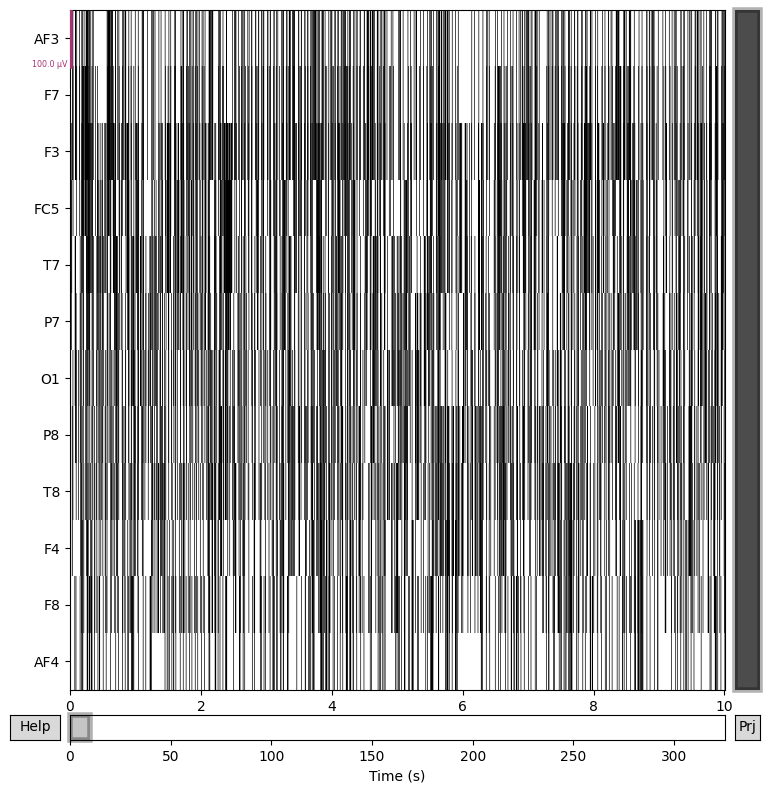

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41631  False  False  False  False  False  False  False  False  False  False   
41632  False  False  False  False  False  False  False  False  False  False   
41633  False  False  False  False  False  False  False  False  False  False   
41634  False  False  False  False  False  False  False  False  False  False   
41635  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


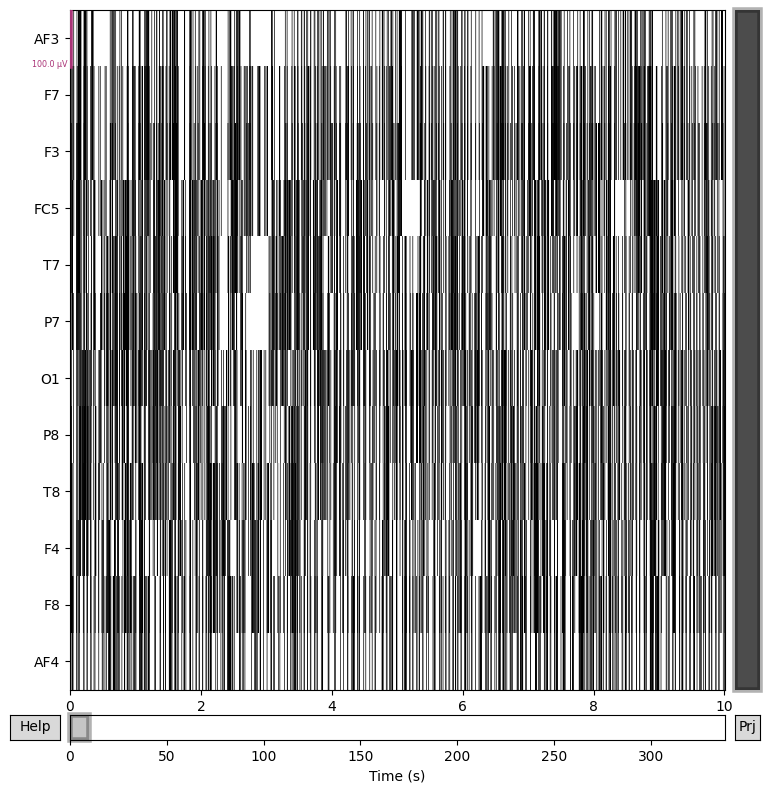

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
43295  False  False  False  False  False  False  False  False  False  False   
43296  False  False  False  False  False  False  False  False  False  False   
43297  False  False  False  False  False  False  False  False  False  False   
43298  False  False  False  False  False  False  False  False  False  False   
43299  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


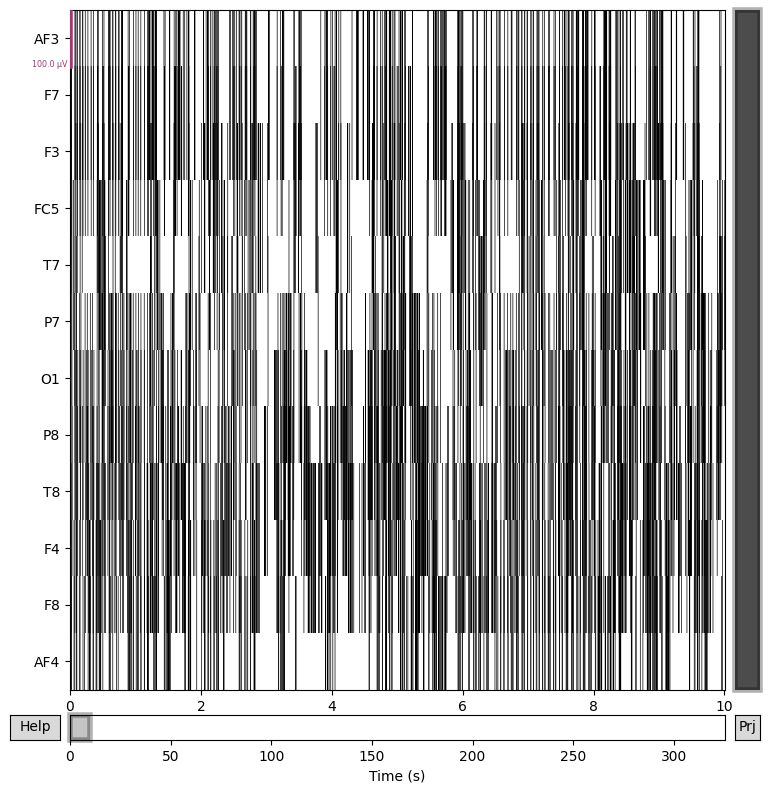

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41654  False  False  False  False  False  False  False  False  False  False   
41655  False  False  False  False  False  False  False  False  False  False   
41656  False  False  False  False  False  False  False  False  False  False   
41657  False  False  False  False  False  False  False  False  False  False   
41658  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


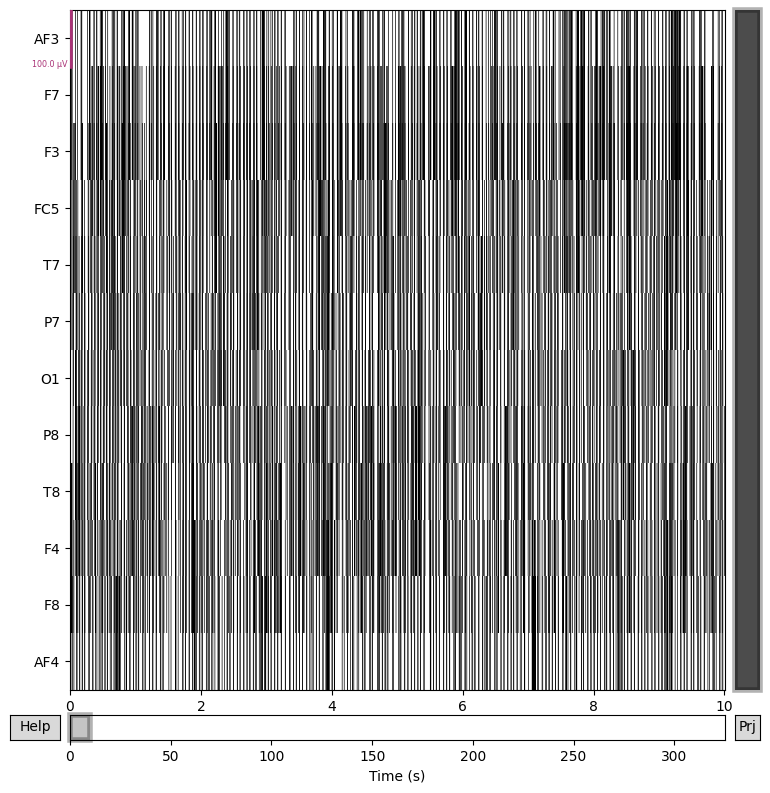

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41614  False  False  False  False  False  False  False  False  False  False   
41615  False  False  False  False  False  False  False  False  False  False   
41616  False  False  False  False  False  False  False  False  False  False   
41617  False  False  False  False  False  False  False  False  False  False   
41618  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


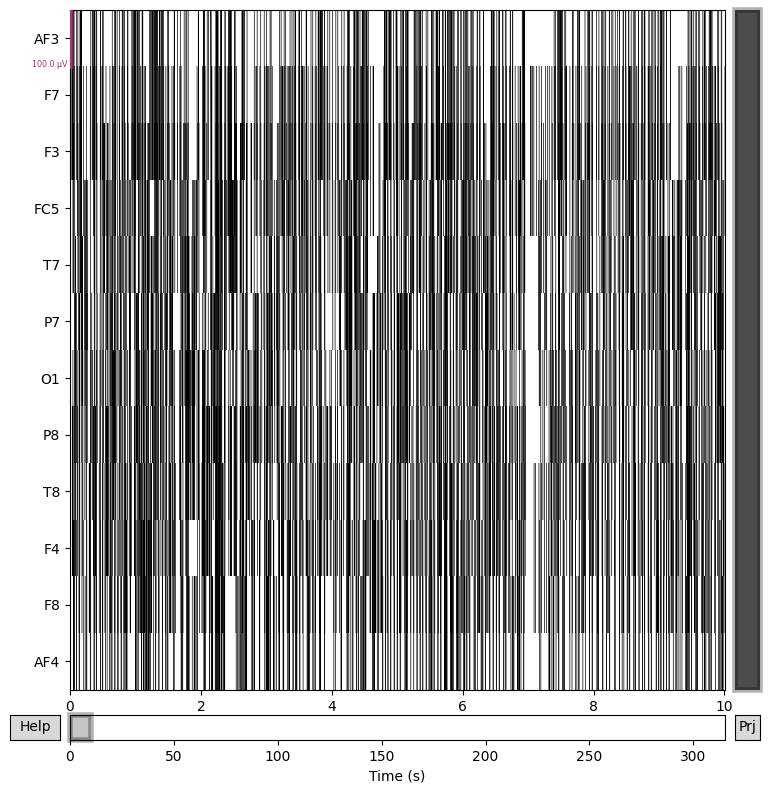

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
40348  False  False  False  False  False  False  False  False  False  False   
40349  False  False  False  False  False  False  False  False  False  False   
40350  False  False  False  False  False  False  False  False  False  False   
40351  False  False  False  False  False  False  False  False  False  False   
40352  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


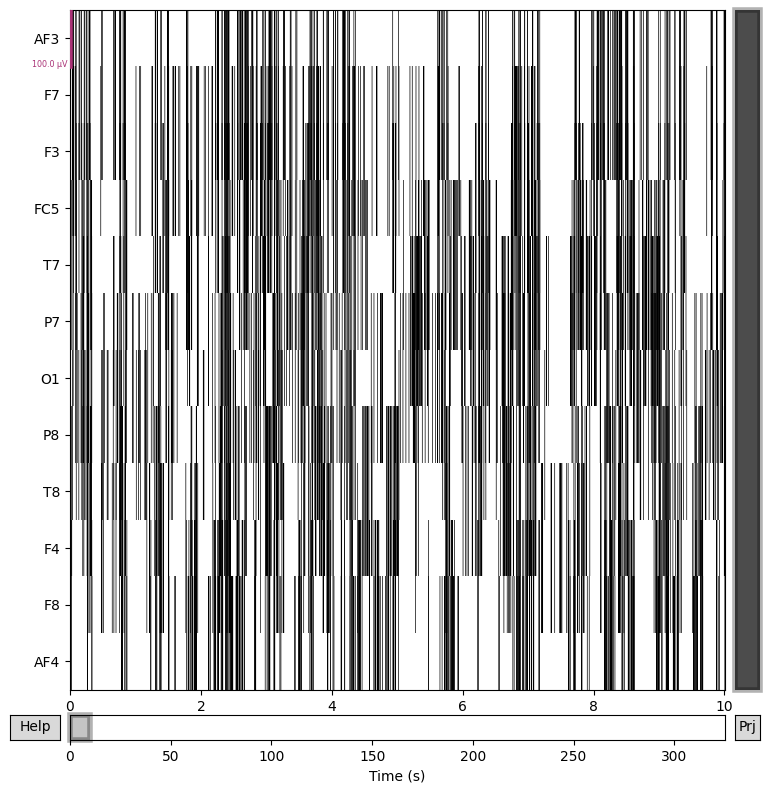

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41614  False  False  False  False  False  False  False  False  False  False   
41615  False  False  False  False  False  False  False  False  False  False   
41616  False  False  False  False  False  False  False  False  False  False   
41617  False  False  False  False  False  False  False  False  False  False   
41618  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


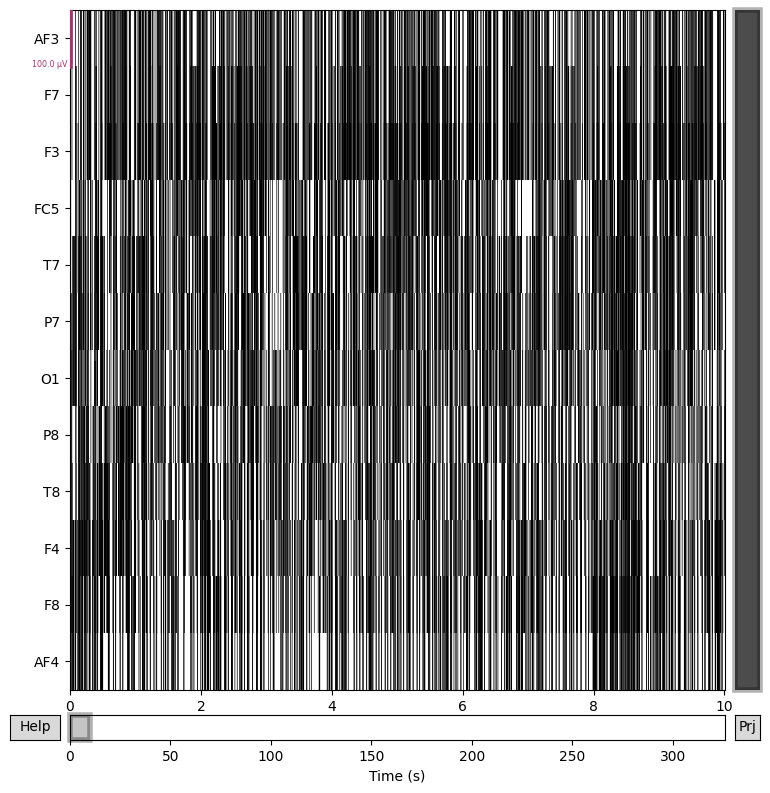

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41731  False  False  False  False  False  False  False  False  False  False   
41732  False  False  False  False  False  False  False  False  False  False   
41733  False  False  False  False  False  False  False  False  False  False   
41734  False  False  False  False  False  False  False  False  False  False   
41735  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


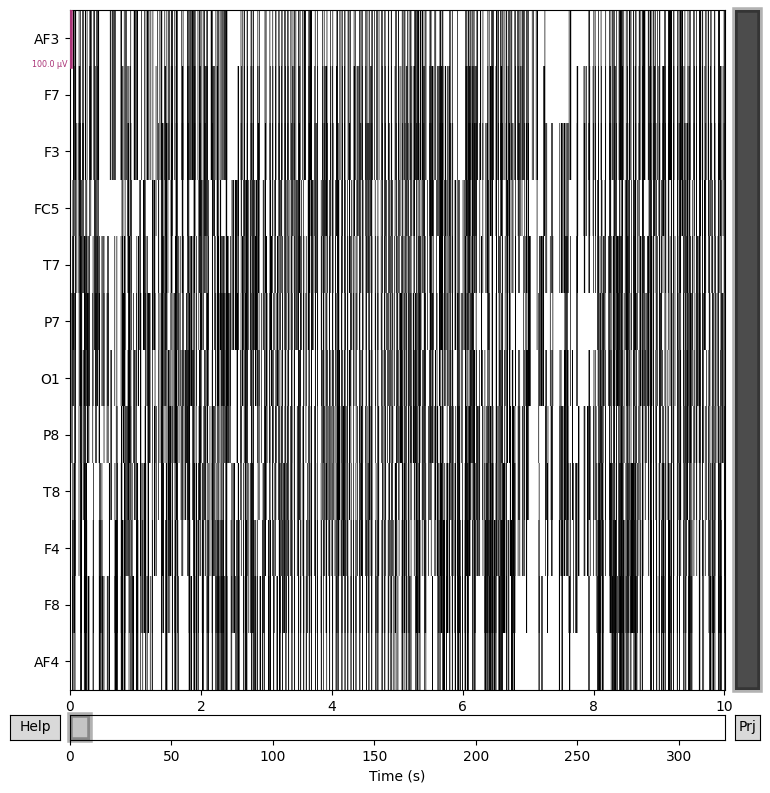

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41320  False  False  False  False  False  False  False  False  False  False   
41321  False  False  False  False  False  False  False  False  False  False   
41322  False  False  False  False  False  False  False  False  False  False   
41323  False  False  False  False  False  False  False  False  False  False   
41324  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


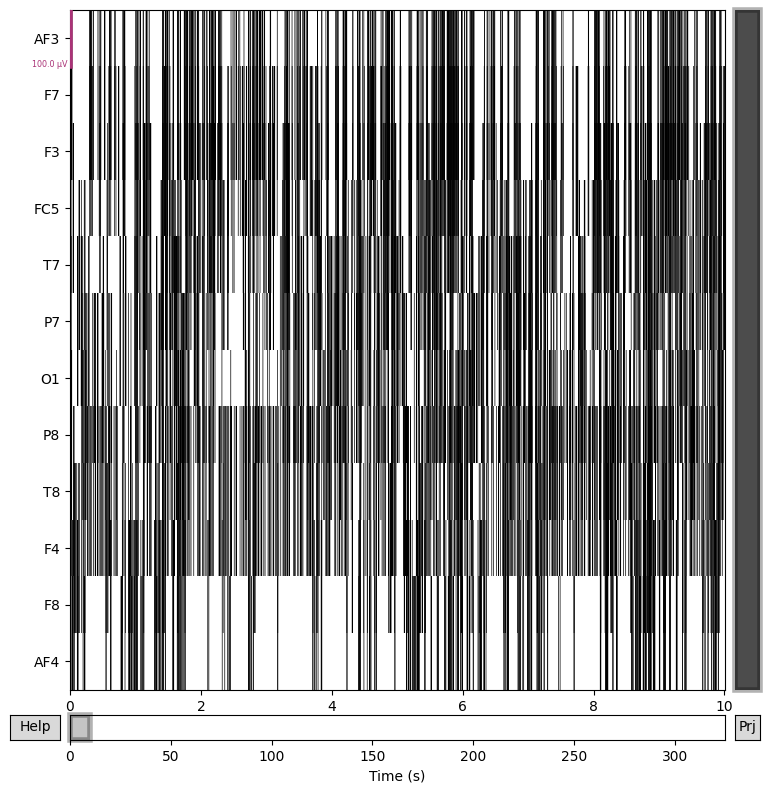

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41580  False  False  False  False  False  False  False  False  False  False   
41581  False  False  False  False  False  False  False  False  False  False   
41582  False  False  False  False  False  False  False  False  False  False   
41583  False  False  False  False  False  False  False  False  False  False   
41584  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


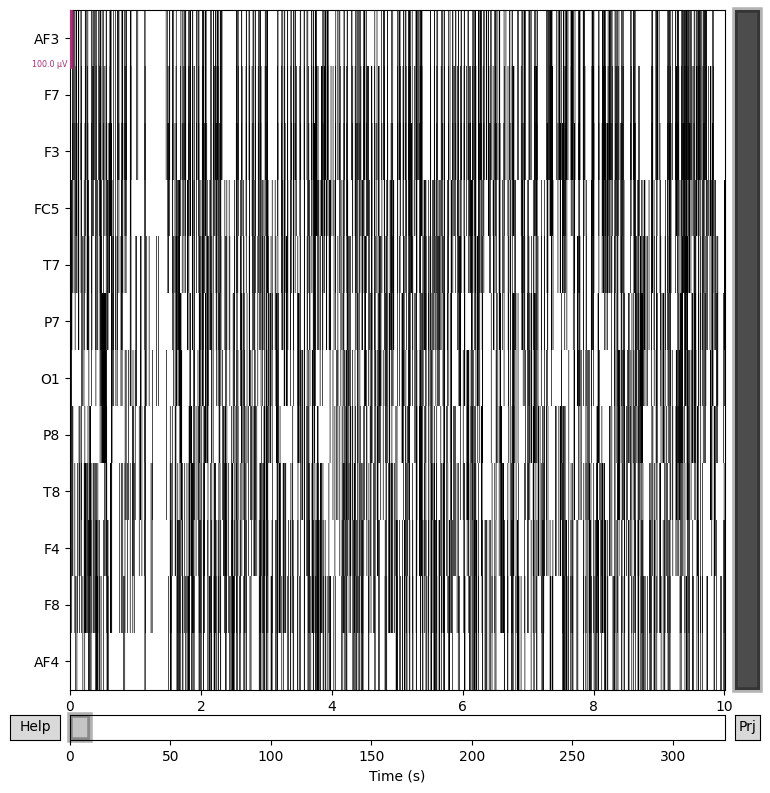

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41720  False  False  False  False  False  False  False  False  False  False   
41721  False  False  False  False  False  False  False  False  False  False   
41722  False  False  False  False  False  False  False  False  False  False   
41723  False  False  False  False  False  False  False  False  False  False   
41724  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


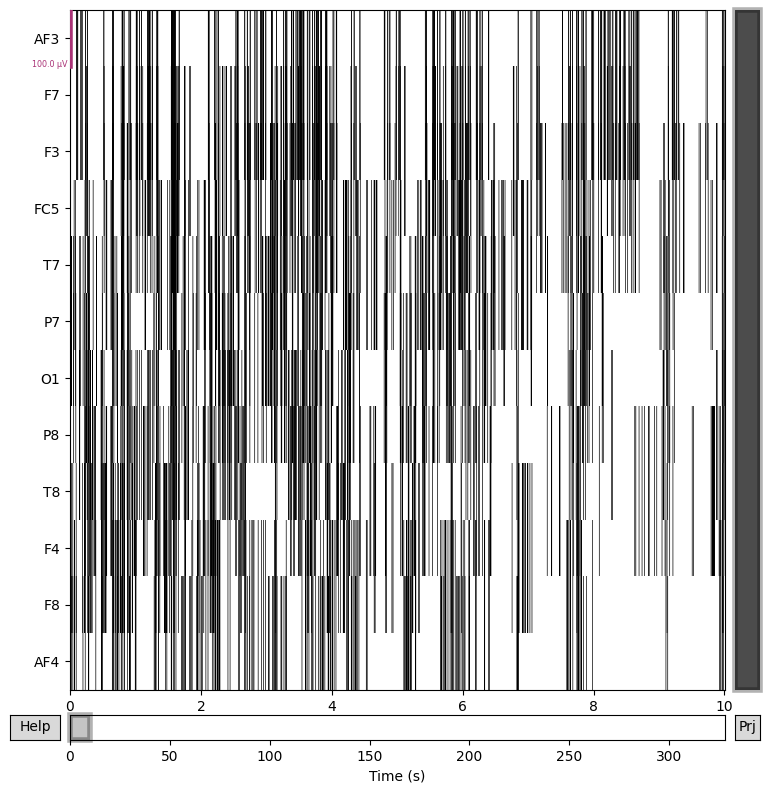

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41975  False  False  False  False  False  False  False  False  False  False   
41976  False  False  False  False  False  False  False  False  False  False   
41977  False  False  False  False  False  False  False  False  False  False   
41978  False  False  False  False  False  False  False  False  False  False   
41979  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


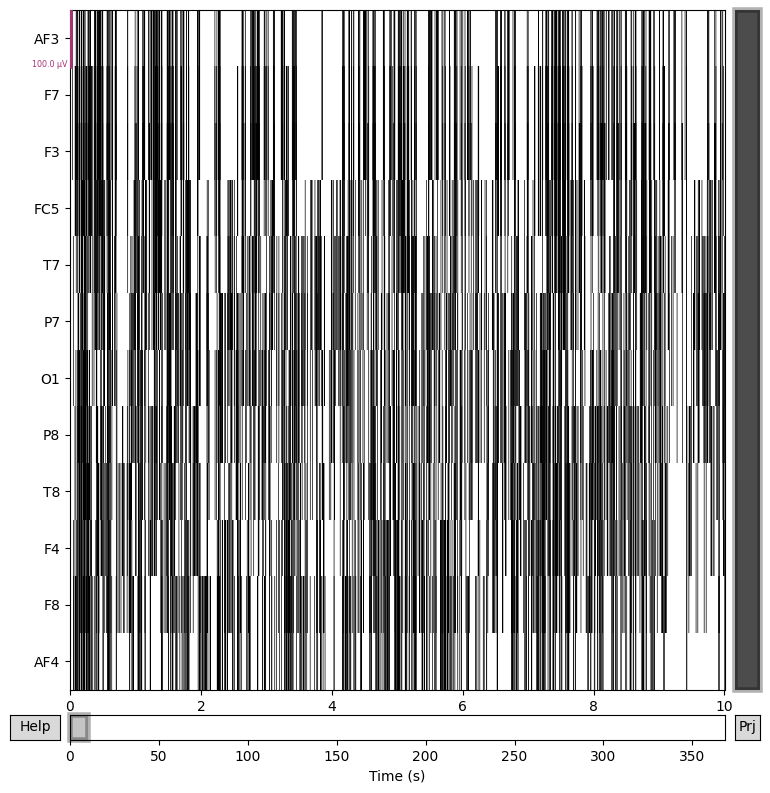

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
47147  False  False  False  False  False  False  False  False  False  False   
47148  False  False  False  False  False  False  False  False  False  False   
47149  False  False  False  False  False  False  False  False  False  False   
47150  False  False  False  False  False  False  False  False  False  False   
47151  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


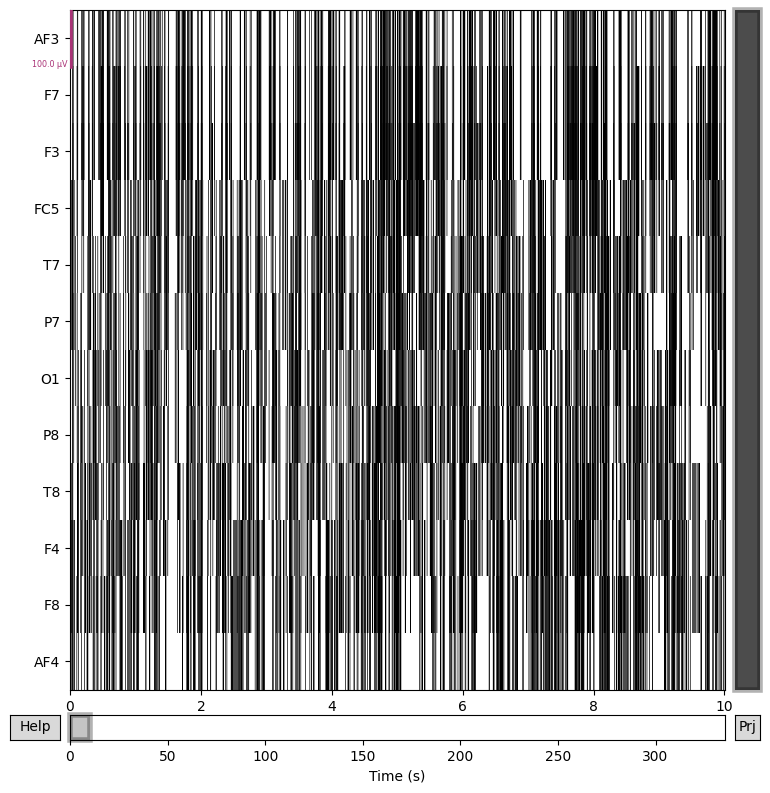

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
42952  False  False  False  False  False  False  False  False  False  False   
42953  False  False  False  False  False  False  False  False  False  False   
42954  False  False  False  False  False  False  False  False  False  False   
42955  False  False  False  False  False  False  False  False  False  False   
42956  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


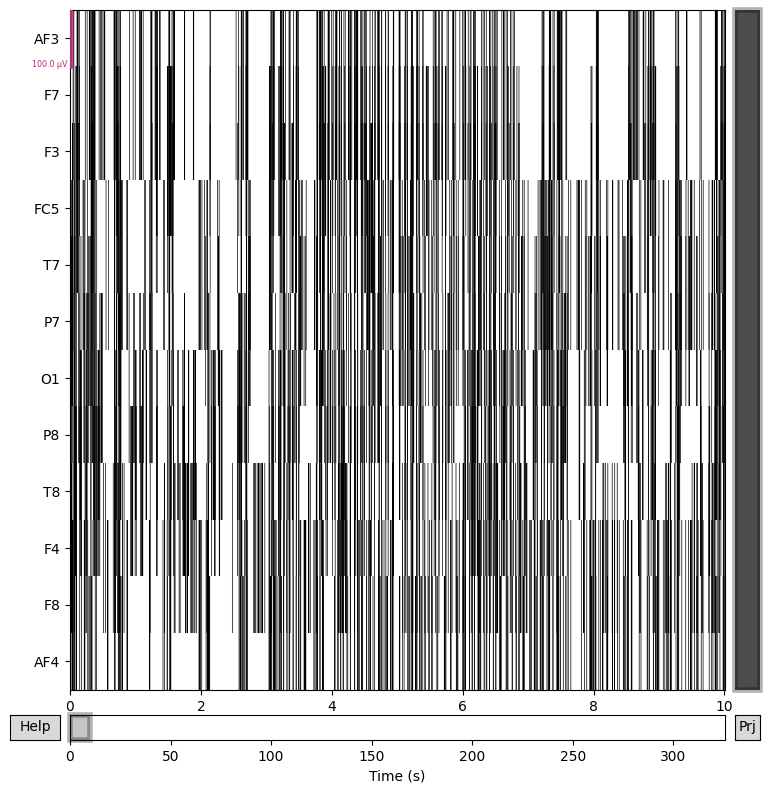

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41686  False  False  False  False  False  False  False  False  False  False   
41687  False  False  False  False  False  False  False  False  False  False   
41688  False  False  False  False  False  False  False  False  False  False   
41689  False  False  False  False  False  False  False  False  False  False   
41690  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


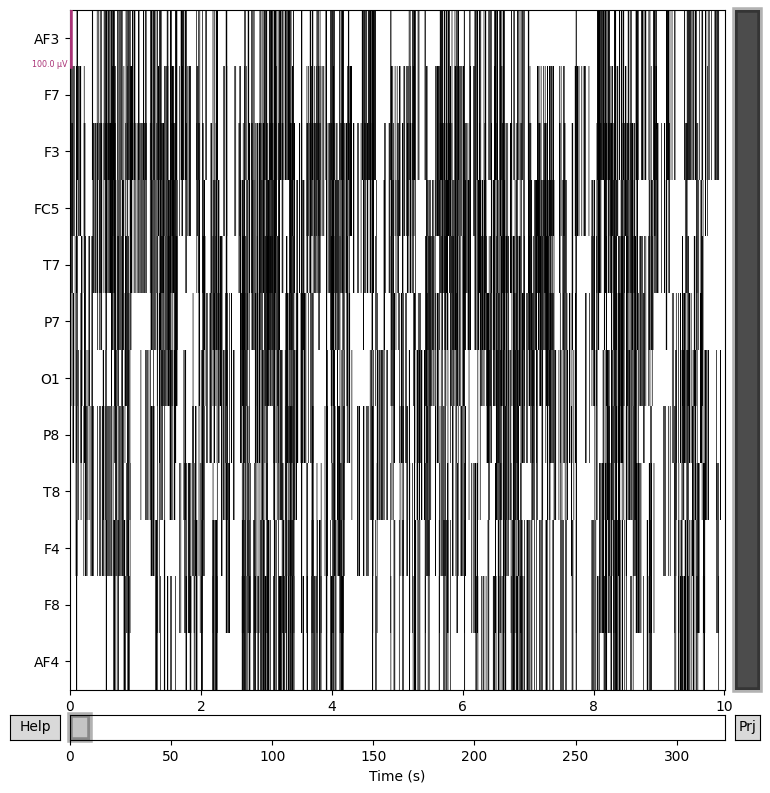

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41451  False  False  False  False  False  False  False  False  False  False   
41452  False  False  False  False  False  False  False  False  False  False   
41453  False  False  False  False  False  False  False  False  False  False   
41454  False  False  False  False  False  False  False  False  False  False   
41455  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


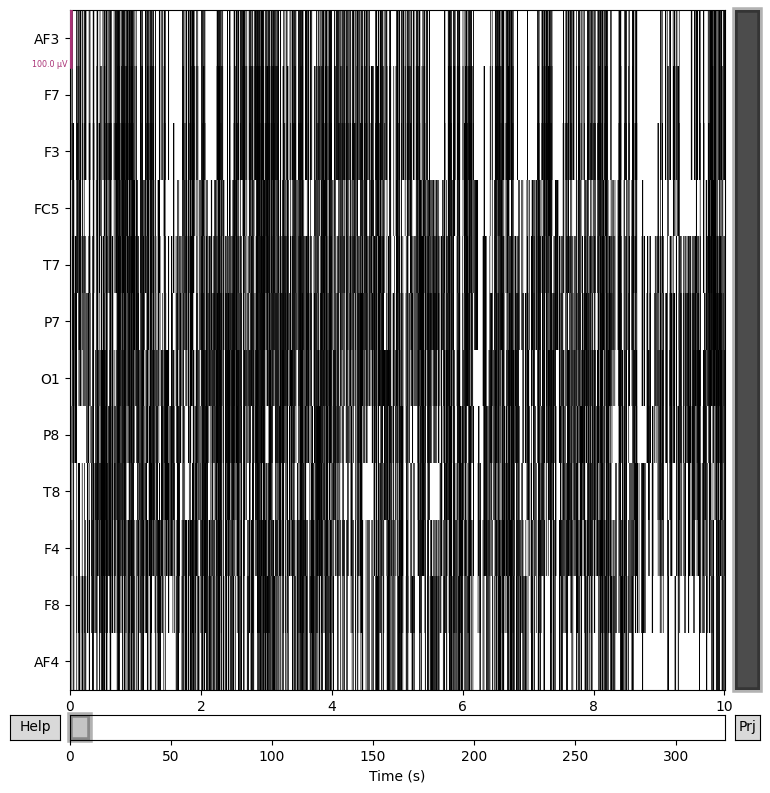

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41495  False  False  False  False  False  False  False  False  False  False   
41496  False  False  False  False  False  False  False  False  False  False   
41497  False  False  False  False  False  False  False  False  False  False   
41498  False  False  False  False  False  False  False  False  False  False   
41499  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


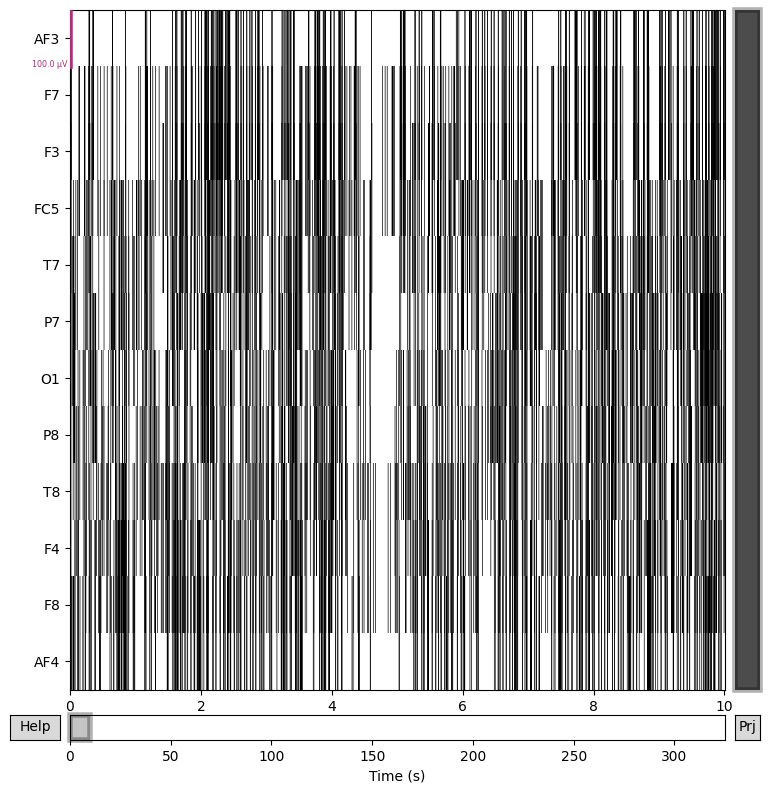

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41610  False  False  False  False  False  False  False  False  False  False   
41611  False  False  False  False  False  False  False  False  False  False   
41612  False  False  False  False  False  False  False  False  False  False   
41613  False  False  False  False  False  False  False  False  False  False   
41614  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


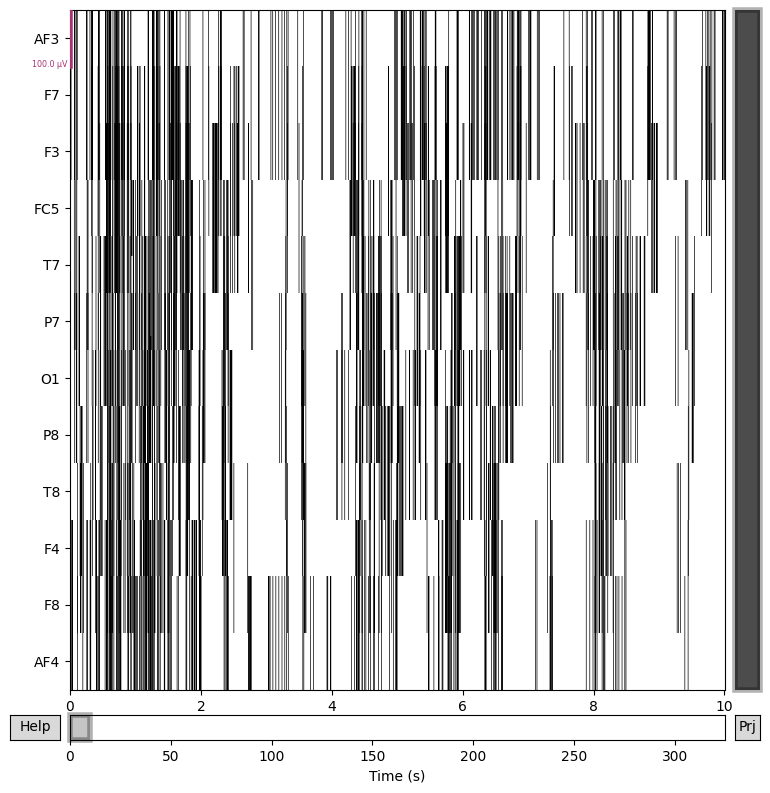

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41571  False  False  False  False  False  False  False  False  False  False   
41572  False  False  False  False  False  False  False  False  False  False   
41573  False  False  False  False  False  False  False  False  False  False   
41574  False  False  False  False  False  False  False  False  False  False   
41575  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


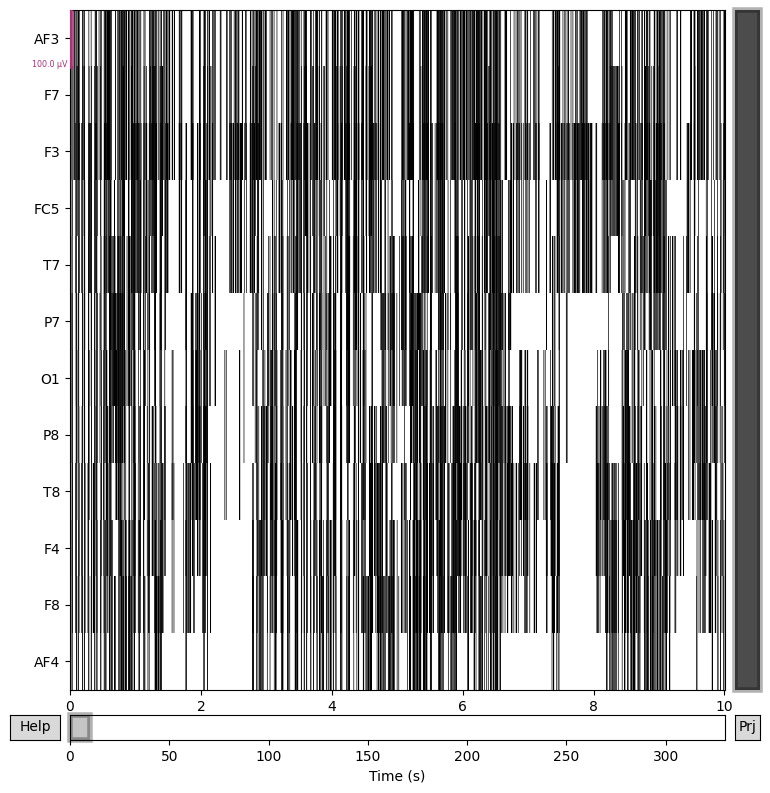

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
42216  False  False  False  False  False  False  False  False  False  False   
42217  False  False  False  False  False  False  False  False  False  False   
42218  False  False  False  False  False  False  False  False  False  False   
42219  False  False  False  False  False  False  False  False  False  False   
42220  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


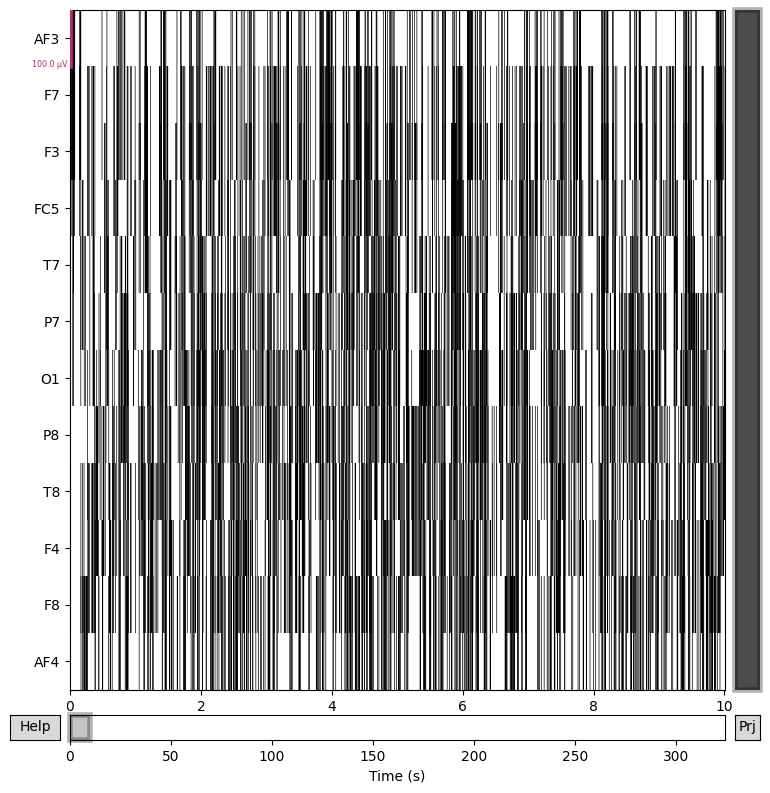

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41512  False  False  False  False  False  False  False  False  False  False   
41513  False  False  False  False  False  False  False  False  False  False   
41514  False  False  False  False  False  False  False  False  False  False   
41515  False  False  False  False  False  False  False  False  False  False   
41516  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


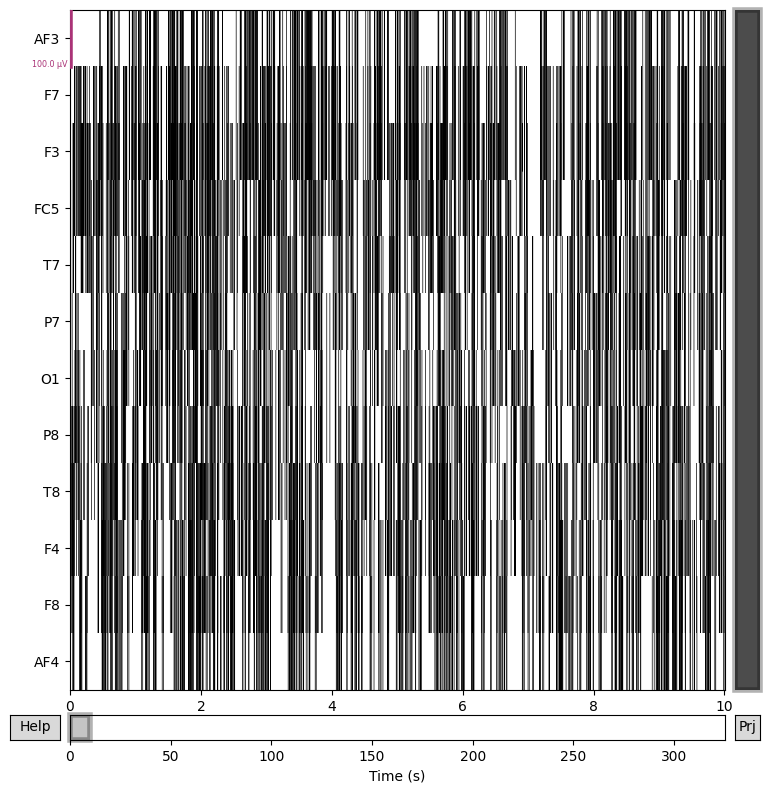

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41625  False  False  False  False  False  False  False  False  False  False   
41626  False  False  False  False  False  False  False  False  False  False   
41627  False  False  False  False  False  False  False  False  False  False   
41628  False  False  False  False  False  False  False  False  False  False   
41629  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


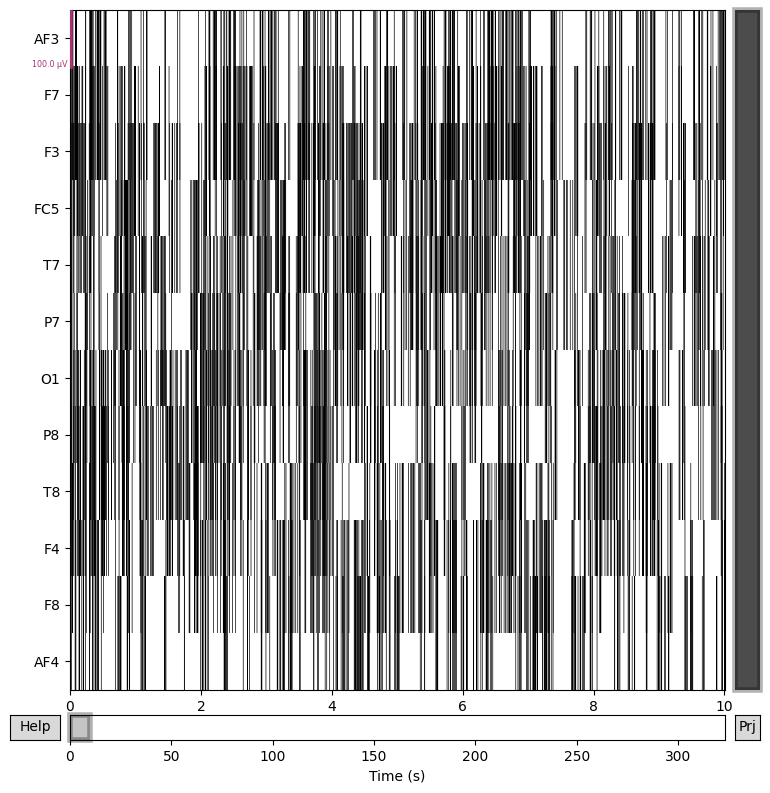

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41357  False  False  False  False  False  False  False  False  False  False   
41358  False  False  False  False  False  False  False  False  False  False   
41359  False  False  False  False  False  False  False  False  False  False   
41360  False  False  False  False  False  False  False  False  False  False   
41361  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


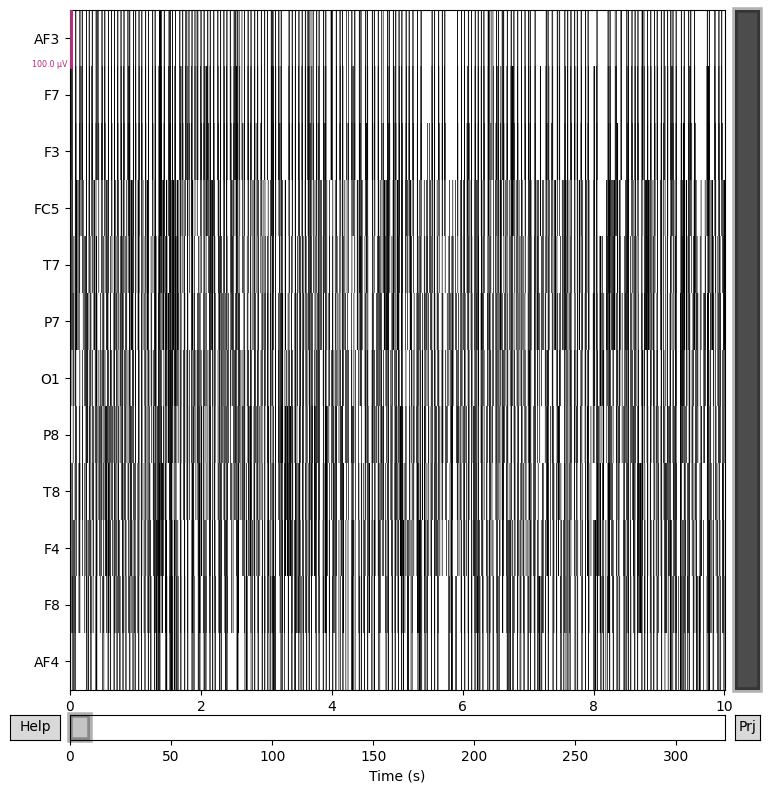

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41474  False  False  False  False  False  False  False  False  False  False   
41475  False  False  False  False  False  False  False  False  False  False   
41476  False  False  False  False  False  False  False  False  False  False   
41477  False  False  False  False  False  False  False  False  False  False   
41478  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


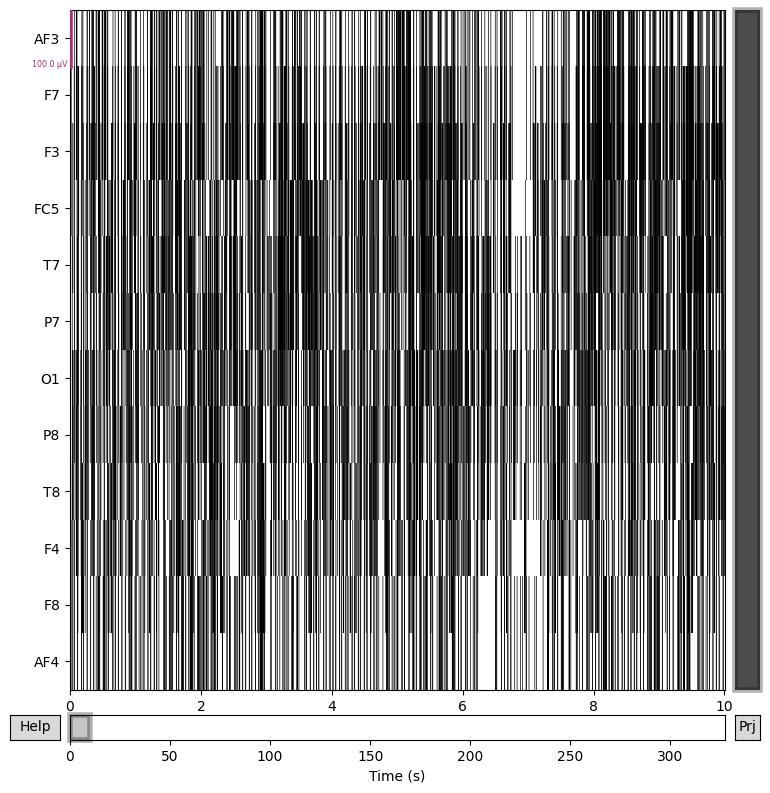

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41889  False  False  False  False  False  False  False  False  False  False   
41890  False  False  False  False  False  False  False  False  False  False   
41891  False  False  False  False  False  False  False  False  False  False   
41892  False  False  False  False  False  False  False  False  False  False   
41893  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


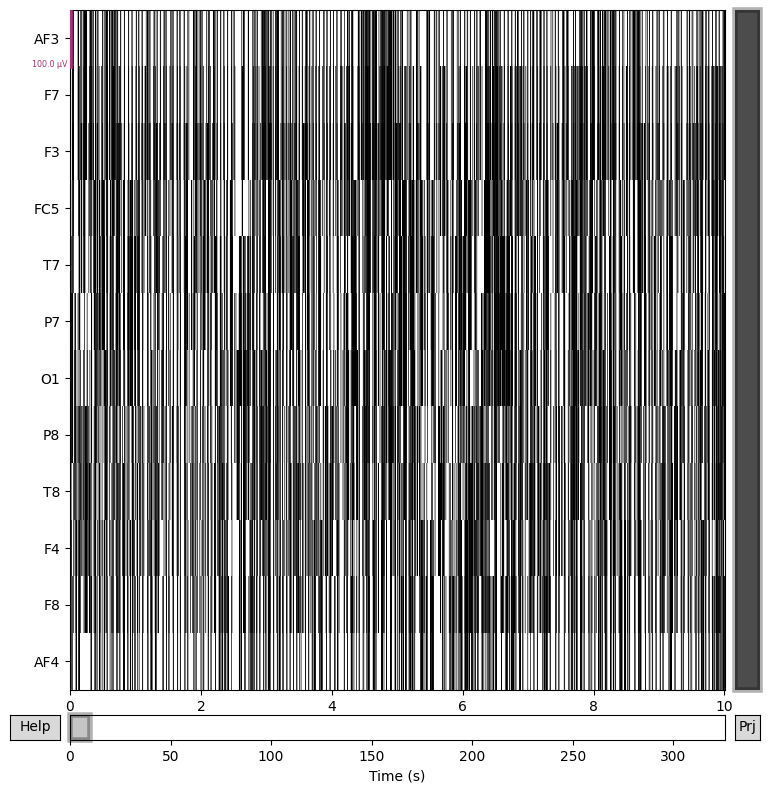

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41695  False  False  False  False  False  False  False  False  False  False   
41696  False  False  False  False  False  False  False  False  False  False   
41697  False  False  False  False  False  False  False  False  False  False   
41698  False  False  False  False  False  False  False  False  False  False   
41699  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


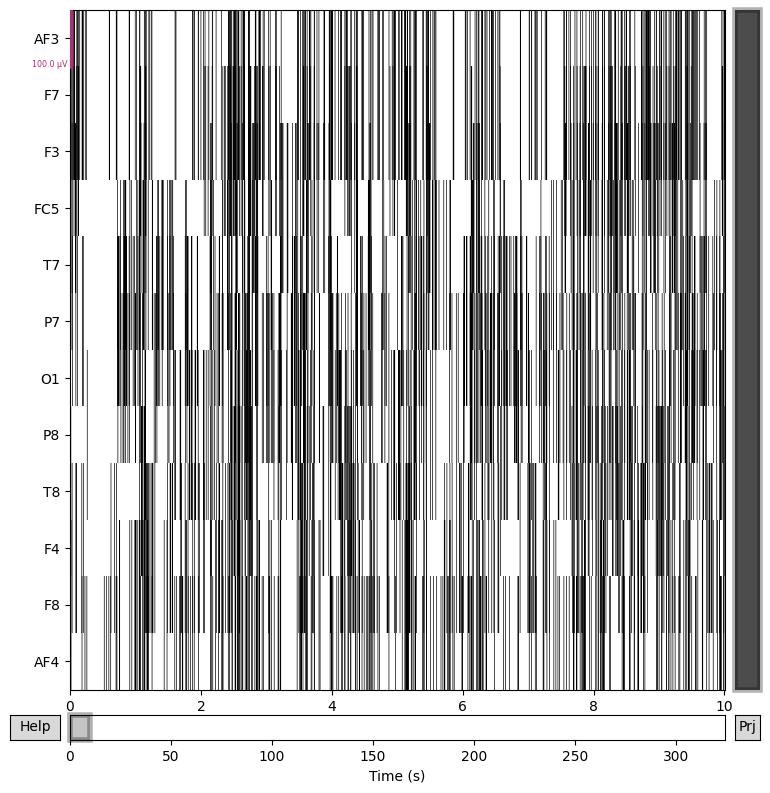

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41508  False  False  False  False  False  False  False  False  False  False   
41509  False  False  False  False  False  False  False  False  False  False   
41510  False  False  False  False  False  False  False  False  False  False   
41511  False  False  False  False  False  False  False  False  False  False   
41512  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


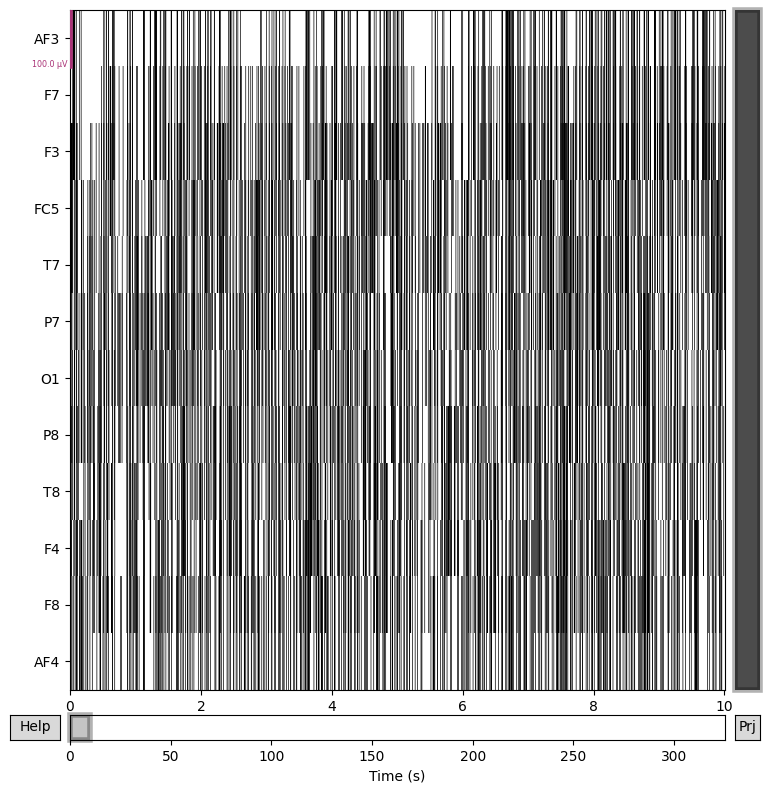

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41637  False  False  False  False  False  False  False  False  False  False   
41638  False  False  False  False  False  False  False  False  False  False   
41639  False  False  False  False  False  False  False  False  False  False   
41640  False  False  False  False  False  False  False  False  False  False   
41641  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


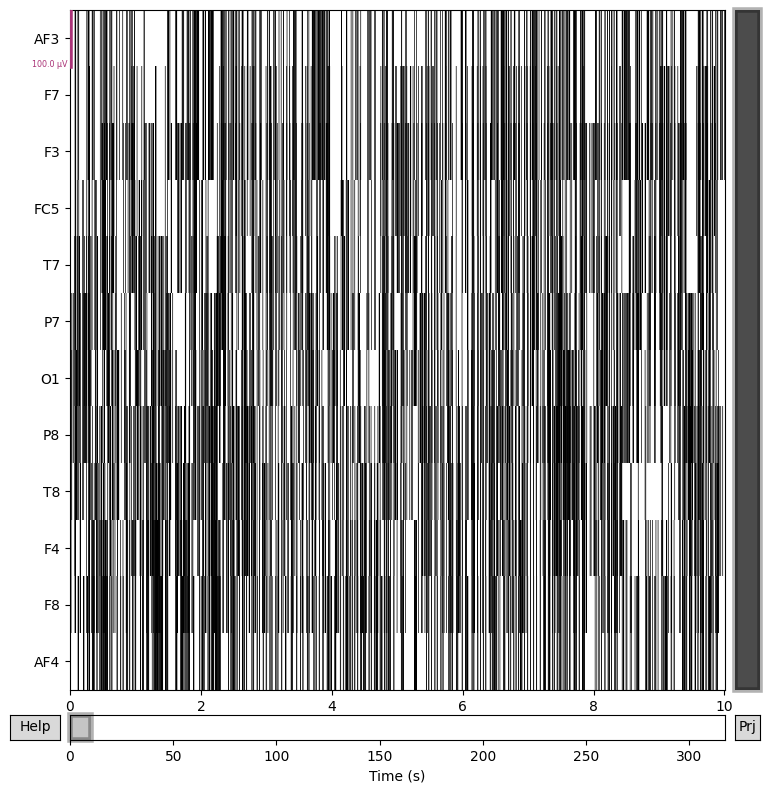

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
40614  False  False  False  False  False  False  False  False  False  False   
40615  False  False  False  False  False  False  False  False  False  False   
40616  False  False  False  False  False  False  False  False  False  False   
40617  False  False  False  False  False  False  False  False  False  False   
40618  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


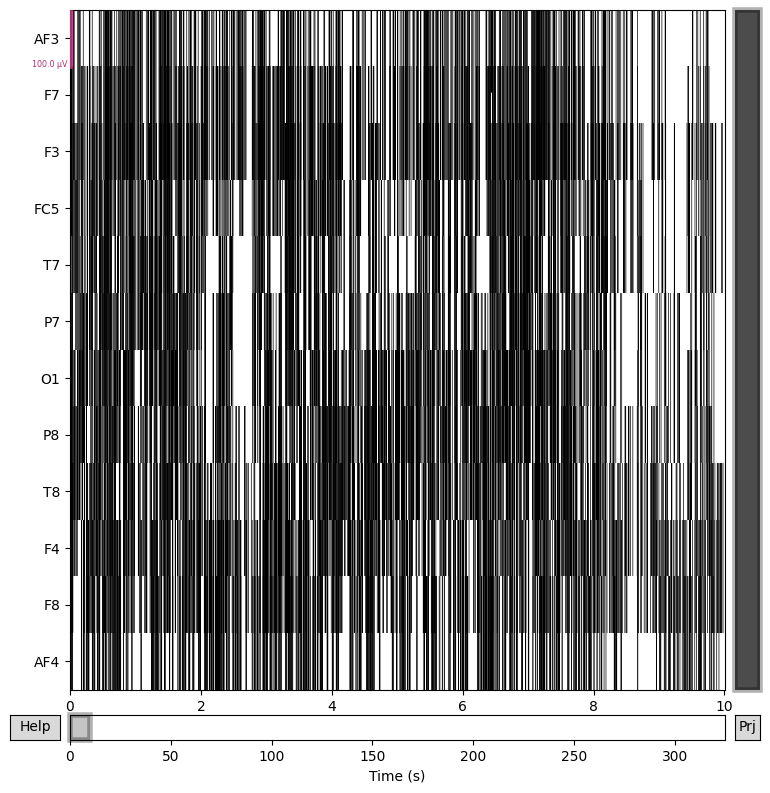

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41585  False  False  False  False  False  False  False  False  False  False   
41586  False  False  False  False  False  False  False  False  False  False   
41587  False  False  False  False  False  False  False  False  False  False   
41588  False  False  False  False  False  False  False  False  False  False   
41589  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


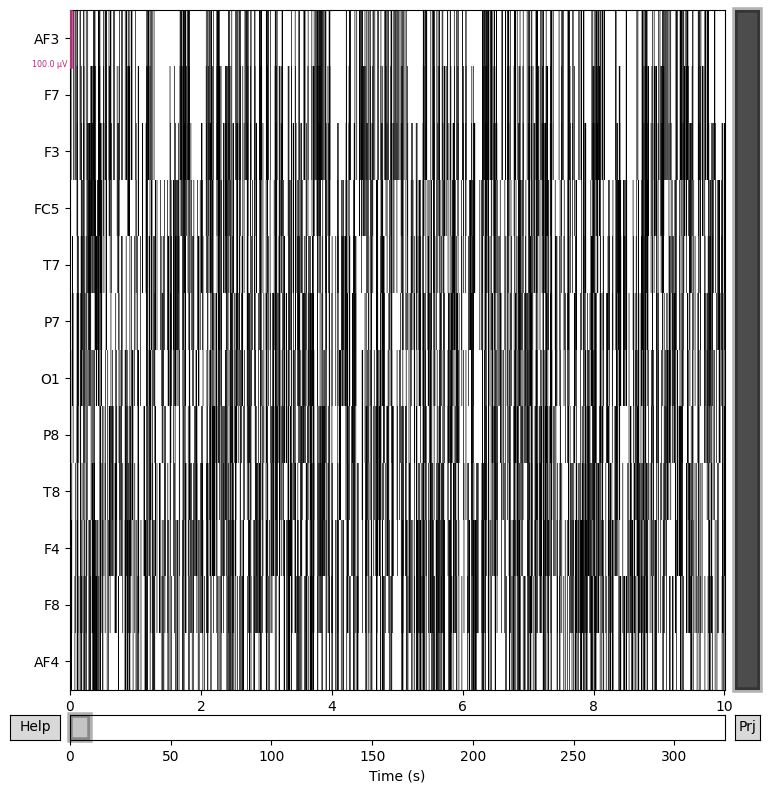

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
41618  False  False  False  False  False  False  False  False  False  False   
41619  False  False  False  False  False  False  False  False  False  False   
41620  False  False  False  False  False  False  False  False  False  False   
41621  False  False  False  False  False  False  False  False  False  False   
41622  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-10-a466a7d07551>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


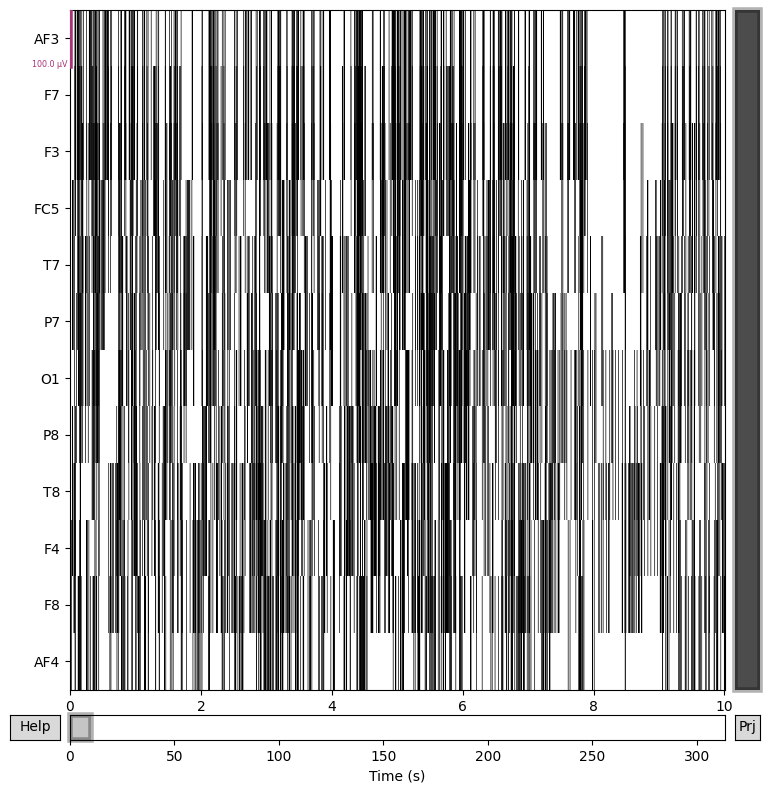

NaN values found in the following locations:
         AF3     F7     F3    FC5     T7     P7     O1     P8     T8     F4  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
40112  False  False  False  False  False  False  False  False  False  False   
40113  False  False  False  False  False  False  False  False  False  False   
40114  False  False  False  False  False  False  False  False  False  False   
40115  False  False  False  False  False  False  False  False  False  False   
40116  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-10-a466a7d07551>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-10-a466a7d07551>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)


In [ ]:
# Interpolation and NaN handling for Raw objects after ICA and filtering
def interpolate_and_handle_nans(raw_cleaned):
    try:
        # Step 1: Interpolate bad channels
        bad_channels = raw_cleaned.info['bads']
        raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels
        raw_cleaned.plot(n_channels=12, scalings=dict(eeg=50e-6))

        # Step 2: Handle NaN values in the EEG data
        eeg_data = pd.DataFrame(raw_cleaned.get_data().T, columns=raw_cleaned.ch_names)
        nan_locations = eeg_data.isna()

        # Print locations of NaN values
        print("NaN values found in the following locations:")
        print(nan_locations)

        # Step 3: Interpolate NaN values in the EEG data
        eeg_data_interpolated = eeg_data.interpolate(method='linear', axis=0)

        # Step 4: Check if any NaN values remain after interpolation
        nan_check = eeg_data_interpolated.isna().sum()
        print("Remaining NaN values after interpolation per column:")
        print(nan_check)

        # Step 5: Replace remaining NaNs with forward fill or backward fill
        eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')

        # Final check for remaining NaN values
        remaining_nans = eeg_data_interpolated.isna().sum()
        print(f"Remaining NaN values after interpolation: {remaining_nans}")

        # Step 6: Mark and interpolate bad channels in the Raw object
        raw_cleaned.info['bads'] = [ch for ch in bad_channels if ch in raw_cleaned.info['ch_names']]
        raw_cleaned.interpolate_bads(reset_bads=True)

        # Update Raw object with interpolated EEG data
        raw_cleaned = mne.io.RawArray(eeg_data_interpolated.T.to_numpy(), raw_cleaned.info)
        return raw_cleaned
    except Exception as e:
        print(f"Error during interpolation and NaN handling: {e}")
        return raw_cleaned

# Dictionary to store the cleaned Raw objects after interpolation and NaN handling
interpolated_raw_word_data = {}

# Process each Raw object for interpolation and NaN handling
for word, raw_object in cleaned_raw_word_data.items():
    print(f"\nProcessing Raw object for word: {word}")

    try:
        # Apply interpolation and NaN handling
        raw_cleaned = interpolate_and_handle_nans(raw_object)

        # Store the cleaned Raw object after interpolation and NaN handling
        interpolated_raw_word_data[word] = raw_cleaned
        print(f"Successfully processed and cleaned Raw object for word: {word}")

    except Exception as e:
        print(f"Failed to process Raw object for word {word}: {e}")


In [ ]:
# Function to apply Z-score normalization to EEG data
def z_score_normalize_eeg_data(raw):
    """
    Normalize the EEG data in the Raw object using Z-score normalization
    (zero mean, unit variance).
    """
    eeg_data = raw.get_data()  # Extract EEG data
    mean = np.mean(eeg_data, axis=1, keepdims=True)  # Compute the mean for each channel
    std = np.std(eeg_data, axis=1, keepdims=True)    # Compute the standard deviation for each channel

    # Z-score normalization
    normalized_data = (eeg_data - mean) / std

    # Replace the data in the Raw object with normalized data
    raw._data = normalized_data
    print("Applied Z-score normalization (zero mean, unit variance).")
    return raw

# Dictionary to store Z-score normalized Raw objects
z_score_normalized_raw_word_data = {}

# Process each interpolated Raw object to apply Z-score normalization
for word, raw_object in interpolated_raw_word_data.items():
    print(f"\nApplying Z-score normalization to Raw object for word: {word}")

    try:
        # Normalize the Raw object
        z_score_normalized_raw = z_score_normalize_eeg_data(raw_object)

        # Store the Z-score normalized Raw object
        z_score_normalized_raw_word_data[word] = z_score_normalized_raw
        print(f"Successfully applied Z-score normalization for word: {word}")

    except Exception as e:
        print(f"Failed to apply Z-score normalization for word {word}: {e}")

# Example: Inspect Z-score normalization for a specific word
target_word = 'اسفل'
if target_word in z_score_normalized_raw_word_data:
    raw = z_score_normalized_raw_word_data[target_word]
    data = raw.get_data()
    print(f"Mean of Z-score normalized data for word {target_word}: {np.mean(data, axis=1)}")
    print(f"Standard deviation of Z-score normalized data for word {target_word}: {np.std(data, axis=1)}")
else:
    print(f"word {target_word} not found in Z-score normalized data.")



Applying Z-score normalization to Raw object for letter: ح
Applied Z-score normalization (zero mean, unit variance).
Successfully applied Z-score normalization for letter: ح

Applying Z-score normalization to Raw object for letter: ج
Applied Z-score normalization (zero mean, unit variance).
Successfully applied Z-score normalization for letter: ج

Applying Z-score normalization to Raw object for letter: د
Applied Z-score normalization (zero mean, unit variance).
Successfully applied Z-score normalization for letter: د

Applying Z-score normalization to Raw object for letter: ت
Applied Z-score normalization (zero mean, unit variance).
Successfully applied Z-score normalization for letter: ت

Applying Z-score normalization to Raw object for letter: خ
Applied Z-score normalization (zero mean, unit variance).
Successfully applied Z-score normalization for letter: خ

Applying Z-score normalization to Raw object for letter: ة
Applied Z-score normalization (zero mean, unit variance).
Success

In [ ]:
# Define the segment length in seconds
SEGMENT_LENGTH_SECONDS = 2  # Duration of each segment
segment_length = FS * SEGMENT_LENGTH_SECONDS  # Number of rows per segment

# Dictionary to store segmented data for each word
segmented_word_data = {}

# Iterate through each word and its RawArray data
for word, raw_data in interpolated_raw_word_data.items():
    print(f"Segmenting data for word: {word}")

    if isinstance(raw_data, mne.io.RawArray):
        # Extract raw numerical data
        data = raw_data.get_data().T
        num_segments = len(data) // segment_length

        # Create segments
        segments = [
            data[i * segment_length: (i + 1) * segment_length]
            for i in range(num_segments)
        ]

        # Optional: Handle partial segment
        if len(data) % segment_length != 0:
            partial_segment = data[num_segments * segment_length:]
            print(f"Partial segment for {word} with length {len(partial_segment)}")

        # Store the segments
        segmented_word_data[word] = segments
        print(f"  {len(segments)} full segments created for word {word}")
    else:
        print(f"Unsupported data type for word {word}: {type(raw_data)}")
        continue

# Iterate through each word and its segmented data
for word, segments in segmented_word_data.items():
    # Convert list of numpy arrays into a single DataFrame
    flat_segments = []
    for i, segment in enumerate(segments):
        # Flatten each segment and add a segment ID (optional)
        segment_df = pd.DataFrame(segment)
        segment_df['Segment_ID'] = i
        flat_segments.append(segment_df)

    # Combine all segments into one DataFrame
    df = pd.concat(flat_segments, ignore_index=True)

    # Save the DataFrame to a CSV
    save_path = os.path.join('/content/drive/MyDrive/preprocessed data', f"{word}_segmented_data.csv")
    df.to_csv(save_path, index=False)
    print(f"Saved {word} segmented data to {save_path}")





Segmenting data for letter: ح
Partial segment for ح with length 164
  162 full segments created for letter ح
Segmenting data for letter: ج
Partial segment for ج with length 36
  169 full segments created for letter ج
Segmenting data for letter: د
Partial segment for د with length 187
  162 full segments created for letter د
Segmenting data for letter: ت
Partial segment for ت with length 147
  162 full segments created for letter ت
Segmenting data for letter: خ
Partial segment for خ with length 161
  157 full segments created for letter خ
Segmenting data for letter: ة
Partial segment for ة with length 147
  162 full segments created for letter ة
Segmenting data for letter: ء
Partial segment for ء with length 8
  163 full segments created for letter ء
Segmenting data for letter: أ
Partial segment for أ with length 109
  161 full segments created for letter أ
Segmenting data for letter: ث
Partial segment for ث with length 113
  162 full segments created for letter ث
Segmenting data for

In [ ]:
#CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense


# Constants
NUM_CHANNELS = 12  # Number of EEG channels
NUM_CLASSES = len(segmented_word_data.keys())  # Number of unique words

# Step 1: Prepare data for LSTM
X = []  # Features
y = []  # Labels

for word, segments in segmented_word_data.items():
    for segment in segments:
        # Append the numpy array directly and ensure correct shape for LSTM
        X.append(segment)  # Assuming `segment` is already a numpy array
        y.append(word)  # The word is the target label


X = np.array(X)  # Shape: (number_of_segments, segment_length, NUM_CHANNELS)
y = np.array(y)  # Shape: (number_of_segments,)

# Encode labels to integers and one-hot encode them
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert words to integers
y_one_hot = to_categorical(y_encoded, num_classes=NUM_CLASSES)  # One-hot encoding

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the CNN model
cnn_model = create_cnn_model((X_train.shape[1], X_train.shape[2]), y_train.shape[1])
cnn_model.summary()

cnn_history = cnn_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)


# Evaluate the model
loss, accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Predictions on test data
y_pred_probs = cnn_model.predict(X_test)  # Predicted probabilities
y_pred_labels = np.argmax(y_pred_probs, axis=-1)  # Predicted class indices
y_true_labels = np.argmax(y_test, axis=-1)  # True class indices

# Print example predictions
print("\nExample Predictions:")
for i in range(5):  # Print first 5 examples
    true_label = label_encoder.inverse_transform([y_true_labels[i]])[0]
    predicted_label = label_encoder.inverse_transform([y_pred_labels[i]])[0]
    print(f"True: {true_label}, Predicted: {predicted_label}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 254, 64)             │           2,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 127, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 125, 32)             │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 62, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 62, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1984)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         127,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 137,534 (537.24 KB)

 Trainable params: 137,534 (537.24 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.0443 - loss: 3.4780 - val_accuracy: 0.0566 - val_loss: 3.3392
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.0622 - loss: 3.2698 - val_accuracy: 0.1015 - val_loss: 3.0831
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.0976 - loss: 3.0219 - val_accuracy: 0.2069 - val_loss: 2.7862
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.1566 - loss: 2.7235 - val_accuracy: 0.2622 - val_loss: 2.4301
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.2618 - loss: 2.3948 - val_accuracy: 0.3830 - val_loss: 2.1295
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3422 - loss: 2.0906 - val_accuracy: 0.4871 - val_loss: 1.7441
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.4187 - loss: 1.7984 - val_accuracy: 0.5733 - val_loss: 1.4715
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4970 - loss: 1.5257 - val_accuracy: 0.6337 - v

In [ ]:
#CNN and LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Flatten, Dense

# Constants
NUM_CHANNELS = 12  # Number of EEG channels
NUM_CLASSES = len(segmented_word_data.keys())  # Number of unique words

# Step 1: Prepare data for CNN + LSTM
X = []  # Features
y = []  # Labels

for word, segments in segmented_word_data.items():
    for segment in segments:
        X.append(segment)  # Assuming `segment` is already a numpy array
        y.append(word)  # The word is the target label


X = np.array(X)  # Shape: (number_of_segments, segment_length, NUM_CHANNELS)
y = np.array(y)  # Shape: (number_of_segments,)

# Encode labels to integers and one-hot encode them
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert words to integers
y_one_hot = to_categorical(y_encoded, num_classes=NUM_CLASSES)  # One-hot encoding

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Define the CNN + LSTM model
def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()
    # CNN layers
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    # LSTM layers
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the CNN + LSTM model
cnn_lstm_model = create_cnn_lstm_model((X_train.shape[1], X_train.shape[2]), y_train.shape[1])
cnn_lstm_model.summary()

cnn_lstm_history = cnn_lstm_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Evaluate the model
loss, accuracy = cnn_lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Predictions on test data
y_pred_probs = cnn_lstm_model.predict(X_test)  # Predicted probabilities
y_pred_labels = np.argmax(y_pred_probs, axis=-1)  # Predicted class indices
y_true_labels = np.argmax(y_test, axis=-1)  # True class indices

# Print example predictions
print("\nExample Predictions:")
for i in range(5):  # Print first 5 examples
    true_label = label_encoder.inverse_transform([y_true_labels[i]])[0]
    predicted_label = label_encoder.inverse_transform([y_pred_labels[i]])[0]
    print(f"True: {true_label}, Predicted: {predicted_label}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 254, 64)             │           2,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 127, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 127, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 125, 32)             │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 62, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 62, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 62, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 62, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 30)                  │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,854 (194.74 KB)

 Trainable params: 49,854 (194.74 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.0336 - loss: 3.4078 - val_accuracy: 0.0566 - val_loss: 3.3949
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.0586 - loss: 3.3446 - val_accuracy: 0.0630 - val_loss: 3.2232
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.0744 - loss: 3.0848 - val_accuracy: 0.0720 - val_loss: 2.9734
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.0860 - loss: 2.9445 - val_accuracy: 0.1272 - val_loss: 2.8354
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.1117 - loss: 2.8282 - val_accuracy: 0.1041 - val_loss: 2.7423
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.1342 - loss: 2.7287 - val_accuracy: 0.1041 - val_loss: 2.6711
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.1417 - loss: 2.6844 - val_accuracy: 0.1388 - val_loss: 2.5597
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.1540 - loss: 2.5940 - val_accuracy: 0.15

In [ ]:
#EEGNet
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, SeparableConv2D, AveragePooling2D, Dense
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten, SpatialDropout2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Constants
NUM_CHANNELS = 12  
NUM_CLASSES = len(segmented_word_data.keys()) 

# Preparing Data 
X = []  # Features
y = []  # Labels

for word, segments in segmented_word_data.items():
    for segment in segments:
        X.append(segment) 
        y.append(word)  # The word is the target label

X = np.array(X)
y = np.array(y)

# Encode labels to integers and one-hot encode them
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert words to integers
y_one_hot = to_categorical(y_encoded, num_classes=NUM_CLASSES)  # One-hot encoding

# Spliting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Adjusting the input shape for Conv2D (Add channel dimension)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
input_shape = X_train.shape[1:]  # (segment_length, NUM_CHANNELS, 1)


# EEGNet Model
def create_eegnet(input_shape, num_classes):
    F1, F2, kernLength, dropoutRate = 16, 32, 64, 0.3

    input1 = Input(shape=input_shape)
    block1 = Conv2D(F1, (kernLength, 1), padding='same', use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((1, NUM_CHANNELS), use_bias=False, depth_multiplier=2)(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = SpatialDropout2D(dropoutRate)(block1)
    block1 = AveragePooling2D((4, 1))(block1)

    block2 = SeparableConv2D(F2, (16, 1), padding='same', use_bias=False)(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((8, 1))(block2)

    # SE Block
    filters = block2.shape[-1]
    se = GlobalAveragePooling2D()(block2)
    se = Dense(filters // 8, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    block2 = Multiply()([block2, se])

    flatten = Flatten()(block2)
    dense = Dense(num_classes, activation='softmax')(flatten)

    return Model(inputs=input1, outputs=dense)

# Model Creation
eegnet_model = create_eegnet(input_shape, NUM_CLASSES)
eegnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training
epochs = 20
batch_size = 32
history = eegnet_model.fit(X_train, y_train, validation_split=0.2, 
                           epochs=epochs, batch_size=batch_size, 
                           callbacks=[early_stopping], verbose=1)

# Test Set Evaluation
test_loss, test_acc = eegnet_model.evaluate(X_test, y_test, verbose=0)
y_true_labels = np.argmax(eegnet_model.predict(X_test), axis=1)
y_pred_labels = np.argmax(y_test, axis=1)

# Print Results
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Print example predictions
print("\nExample Predictions:")
for i in range(5):  # Print first 5 examples
    true_label = label_encoder.inverse_transform([y_true_labels[i]])[0]
    predicted_label = label_encoder.inverse_transform([y_pred_labels[i]])[0]
    print(f"True: {true_label}, Predicted: {predicted_label}")